# Website A/B Testing - Lab

## Introduction

In this lab, you'll get another chance to practice your skills at conducting a full A/B test analysis. It will also be a chance to practice your data exploration and processing skills! The scenario you'll be investigating is data collected from the homepage of a music app page for audacity.

## Objectives

You will be able to:
* Analyze the data from a website A/B test to draw relevant conclusions
* Explore and analyze web action data

## Exploratory Analysis

Start by loading in the dataset stored in the file 'homepage_actions.csv'. Then conduct an exploratory analysis to get familiar with the data.

> Hints:
    * Start investigating the id column:
        * How many viewers also clicked?
        * Are there any anomalies with the data; did anyone click who didn't view?
        * Is there any overlap between the control and experiment groups? 
            * If so, how do you plan to account for this in your experimental design?

In [1]:
#Your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
df = pd.read_csv('homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8188 entries, 0 to 8187
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  8188 non-null   object
 1   id         8188 non-null   int64 
 2   group      8188 non-null   object
 3   action     8188 non-null   object
dtypes: int64(1), object(3)
memory usage: 256.0+ KB


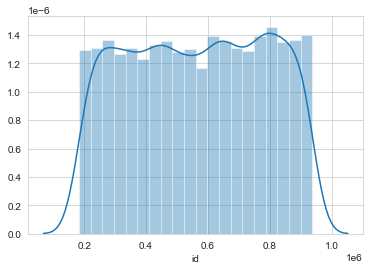

In [11]:
sns.distplot(df['id'])

In [21]:
df[df['action']=='click']['id']

8       349125
12      601714
15      487634
17      468601
21      555973
         ...  
8162    451198
8164    252195
8167    344770
8180    615849
8182    795585
Name: id, Length: 1860, dtype: int64

In [22]:
df[df['action']=='view']['id']

0       804196
1       434745
2       507599
3       671993
4       536734
         ...  
8183    192060
8184    755912
8185    458115
8186    505451
8187    461199
Name: id, Length: 6328, dtype: int64

In [72]:
cids = set(df[df.action=='click']['id'].unique())
vids = set(df[df.action=='view']['id'].unique())
print("Number of viewers: {} \tNumber of clickers: {}".format(len(vids), len(cids)))
print("Number of Viewers who didn't click: {}".format(len(vids-cids)))
print("Number of Clickers who didn't view: {}".format(len(cids-vids)))

Number of viewers: 6328 	Number of clickers: 1860
Number of Viewers who didn't click: 4468
Number of Clickers who didn't view: 0


In [73]:
eids = set(df[df.group=='experiment']['id'].unique())
cids = set(df[df.group=='control']['id'].unique())
print('Overlap of experiment and control groups: {}'.format(len(eids&cids)))

Overlap of experiment and control groups: 0


In [74]:
df['count'] = 1
#df.fillna(value=0)

In [75]:
#customers either clicked or viewed
df_expt = df[df['group']=='experiment'][['id','action','count']]
df_expt.fillna(value=0)
df_expt

,id,action,count
0,804196,view,1
1,434745,view,1
2,507599,view,1
4,536734,view,1
5,681598,view,1
...,...,...,...
8179,615849,view,1
8180,615849,click,1
8183,192060,view,1
8184,755912,view,1


In [76]:
df_ctrl = df[df['group']=='control'][['id','action','count']]
df_ctrl.fillna(value=0)

,id,action,count
3,671993,view,1
9,560027,view,1
23,281985,view,1
24,407864,view,1
25,342984,view,1
...,...,...,...
8178,616692,view,1
8181,795585,view,1
8182,795585,click,1
8186,505451,view,1


In [77]:
df_ctrl['count'].value_counts()

1    4264
Name: count, dtype: int64

In [84]:
df_expt.groupby('action').count()

,id,count
action,,
click,928,928
view,2996,2996


In [96]:
df['id'].value_counts()

363314    2
368962    2
568156    2
267099    2
322257    2
         ..
419672    1
448358    1
761703    1
929641    1
196608    1
Name: id, Length: 6328, dtype: int64

In [108]:
df[(df['id']==183089)]

,timestamp,id,group,action,count
376,2016-09-29 23:04:42.722325,183089,control,view,1


In [110]:
df[(df['id']==182994)]

,timestamp,id,group,action,count
5639,2016-12-14 13:19:00.940677,182994,control,view,1
5640,2016-12-14 13:20:29.564080,182994,control,click,1


In [109]:
df[(df['id']==183089) & (df.group=='experiment')].pivot(index='id', columns='action', values='count')

action
id


In [113]:
#Convert clicks into a binary variable on a user-by-user-basis
control = df[df.group=='control'].pivot(index='id', columns='action', values='count')
control = control.fillna(value=0)

experiment = df[df.group=='experiment'].pivot(index='id', columns='action', values='count')
experiment = experiment.fillna(value=0)



print("Sample sizes:\tControl: {}\tExperiment: {}".format(len(control), len(experiment)))
print("Total Clicks:\tControl: {}\tExperiment: {}".format(control.click.sum(), experiment.click.sum()))
print("Average click rate:\tControl: {}\tExperiment: {}".format(control.click.mean(), experiment.click.mean()))
control.head(10)

Sample sizes:	Control: 3332	Experiment: 2996
Total Clicks:	Control: 932.0	Experiment: 928.0
Average click rate:	Control: 0.2797118847539016	Experiment: 0.3097463284379172


action,click,view
id,,
182994,1.0,1.0
183089,0.0,1.0
183248,1.0,1.0
183515,0.0,1.0
183524,0.0,1.0
183576,0.0,1.0
183617,1.0,1.0
184212,1.0,1.0
184390,0.0,1.0


## Conduct a Statistical Test

Conduct a statistical test to determine whether the experimental homepage was more effective than that of the control group.

In [114]:
#Your code here
import flatiron_stats as fs
fs.p_value_welch_ttest(control.click, experiment.click)

0.004466402814337078

## Verifying Results

One sensible formulation of the data to answer the hypothesis test above would be to create a binary variable representing each individual in the experiment and control group. This binary variable would represent whether or not that individual clicked on the homepage; 1 for they did and 0 if they did not. 

The variance for the number of successes in a sample of a binomial variable with n observations is given by:

## $n\bullet p (1-p)$

Given this, perform 3 steps to verify the results of your statistical test:
1. Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 
2. Calculate the number of standard deviations that the actual number of clicks was from this estimate. 
3. Finally, calculate a p-value using the normal distribution based on this z-score.

### Step 1:
Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 

In [116]:
#Your code here
control_rate = control.click.mean()
expected_experiment_clicks_under_null = control_rate * len(experiment)
print(expected_experiment_clicks_under_null)

838.0168067226891


### Step 2:
Calculate the number of standard deviations that the actual number of clicks was from this estimate.

In [122]:
#Your code here
experiment_rate = experiment.click.mean()
actual_rate=experiment_rate*len(experiment)
actual_rate

928.0

In [120]:
n = len(experiment)
p = control_rate
var = n * p * (1-p)
std = np.sqrt(var)
print(std)

24.568547907005815


In [124]:
actual_experiment_clicks = experiment.click.sum()
#z_score = (actual_rate - expected_experiment_clicks_under_null)/std
z_score = (actual_experiment_clicks - expected_experiment_clicks_under_null)/std
print(z_score)

3.6625360854823588


In [128]:
actual_experiment_clicks, actual_rate
experiment.click.mean()*len(experiment)

928.0

### Step 3: 
Finally, calculate a p-value using the normal distribution based on this z-score.

In [130]:
#Your code here
import scipy.stats as stats
p_val = stats.norm.sf(z_score) #or 1 - stats.norm.cdf(z_score)
print(p_val)

0.00012486528006951198


### Analysis:

Does this result roughly match that of the previous statistical test?

> Comment: **Your analysis here**
#Comment: Yes, while the p-value is slightly lower, 
#both would lead to confident rejection of the null hypothesis. 
#The experimental page appears to be a more effective design.

## Summary

In this lab, you continued to get more practice designing and conducting AB tests. This required additional work preprocessing and formulating the initial problem in a suitable manner. Additionally, you also saw how to verify results, strengthening your knowledge of binomial variables, and reviewing initial statistical concepts of the central limit theorem, standard deviation, z-scores, and their accompanying p-values.